In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import sklearn
import pylab

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz
from sklearn import model_selection
from scipy.stats import normaltest
from scipy.stats import kurtosis
from scipy.stats import kstest
from scipy. stats import skew
from sklearn import metrics
from sklearn import tree

# specifies number of rows to show.
pd.set_option('display.max_rows', 300)

# specifies default number format to 4 decimal places.
pd.options.display.float_format = '{:40,.4f}'.format

# specifies that graphs should use ggplot styling.
plt.style.use('ggplot')
%matplotlib inline

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/henry-kang-7/CASA0004/main/csv/DS_LHS.csv')

In [3]:
df.head(5)
temp = df[['immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CumulativeImmune        1000 non-null   float64
 1   CumulativePopulation    1000 non-null   float64
 2   CumulativeSick          1000 non-null   float64
 3   CumulativeSusceptible   1000 non-null   float64
 4   CumulativeVaccinated    1000 non-null   float64
 5   ProportionImmune        1000 non-null   float64
 6   ProportionSick          1000 non-null   float64
 7   ProportionSusceptible   1000 non-null   float64
 8   ProportionVaccinated    1000 non-null   float64
 9   immunityPeriod          1000 non-null   float64
 10  infectiousPeriod        1000 non-null   float64
 11  socialDistancingLevels  1000 non-null   float64
 12  vaccinationRate         1000 non-null   float64
 13  openmole$experiment     1000 non-null   int64  
 14  temp                    1000 non-null   f

Text(0.5, 1.0, 'Correlation Matrix')

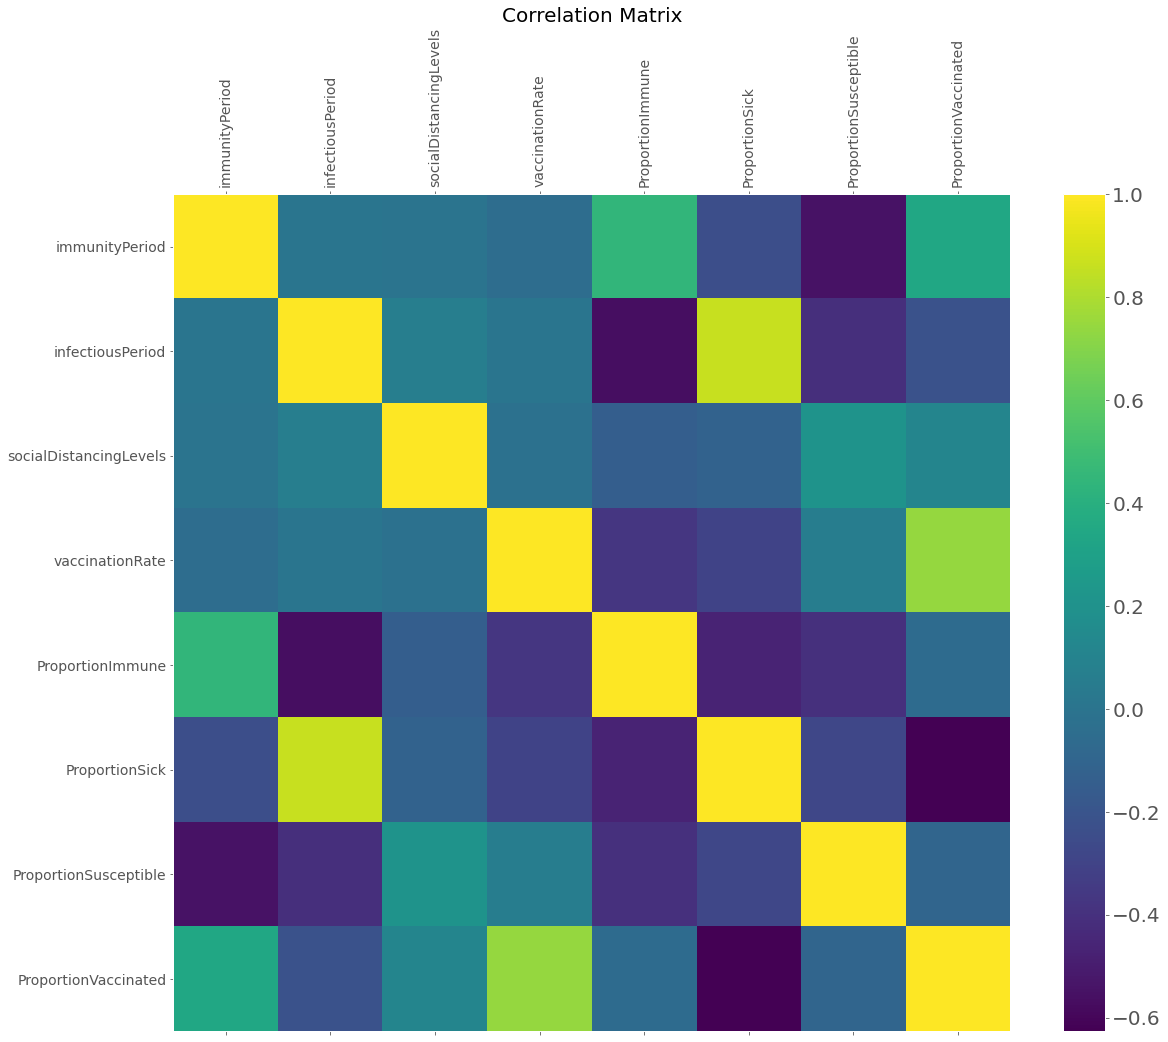

In [5]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(temp.corr(), fignum=f.number)

# x and y ticks and its properties.
# shape[0] = rows, sahpe[1] = columns
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)

# color bar and its properties.
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# title of matrix.
plt.title('Correlation Matrix', fontsize=20)

In [6]:
x = df[['immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate']]
y = df['ProportionSick']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, random_state=1024)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

# check the index of train_x and train_y - they should be identical. 
# the index indicates which rows from the original data.
print(X_train.index.identical(y_train.index))
print(X_test.index.identical(y_test.index))
print(X_val.index.identical(y_val.index))

(700, 4)
(700,)
(210, 4)
(210,)
(90, 4)
(90,)
True
True
True


In [9]:
lr = LinearRegression()

lr.fit(X=X_train, y=y_train)

LinearRegression()

In [10]:
# fit a lineare regression model using statsmodel
regressor_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train)).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ProportionSick   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     2574.
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:28:11   Log-Likelihood:                 3393.0
No. Observations:                 700   AIC:                            -6776.
Df Residuals:                     695   BIC:                            -6753.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3176      0.001    239.033      0.000       0.315       0.320
immunityPeriod            -0.0033      0.000    -26.529      0.000      -0.004      -0.003
infectiousPeriod           0.0115      0.000     91.011      0.000       0.011       0.012
socialDistancingLevels    -0.0023      0.000    -18.149      0.000      -0.003      -0.002
vaccinationRate           -0.0041      0.000    -33.029      0.000      -0.004      -0.004
==============================================================================
Omnibus:                       36.870   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.285
Skew:                          -0.578   Prob(JB):                     1.08e-09
Kurtosis:                       3.278   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# merge training and validation data, as required by GridSearchCV
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# the index list of training and validation data in the merged dataset
# in X_train_val, the first n rows are from X_train and the remaining rows are from X_val. Here n=X_train.shape[0]
ind_train = list(range(X_train.shape[0]))
ind_val = list(range(X_train.shape[0], X_train_val.shape[0]))

In [12]:
# values of n_estimators
parameters = {'n_estimators': [800, 900, 950, 1000, 1050]}


randomState_rf = 1500
rf = RandomForestRegressor(random_state=randomState_rf)

# CV: An iterable yielding (train, test) splits as arrays of indices.
clf = model_selection.GridSearchCV(rf, parameters, cv=[(ind_train, ind_val)])

clf.fit(X_train_val, y_train_val)

# we can query the best parameter value and its accuracy score
print("The best parameter value is: ")
print(clf.best_params_)
print("The best score is: ")
print(clf.best_score_)

The best parameter value is: 
{'n_estimators': 900}
The best score is: 
0.9595577049121597


In [13]:
rf_final = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'], random_state=randomState_rf)
rf_final.fit(X_train, y_train)

RandomForestRegressor(n_estimators=900, random_state=1500)

In [14]:
print("R2 on the training data:")
print(rf_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(rf_final.score(X=X_test, y=y_test))

R2 on the training data:
0.9949961164413985
R2 on the testing data:
0.960037709543947


In [15]:
y_pred = rf_final.predict(X_test)

In [16]:
df_temp = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_temp.head(10)

,Actual,Predicted
35,0.3095,0.3092
692,0.3155,0.3152
101,0.3022,0.3018
773,0.3144,0.3140
435,0.3148,0.3121
785,0.3017,0.3022
50,0.3038,0.3030
354,0.3196,0.3199
970,0.3142,0.3117
874,0.3142,0.3146


C:\Users\gear7\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\gear7\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


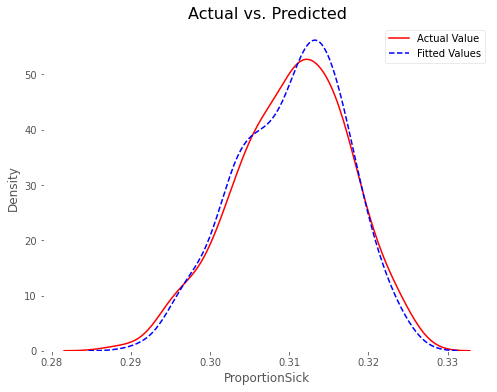

In [17]:
plt.figure(figsize=(8, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values", kde_kws={'linestyle':'--'}, ax=ax)
plt.title('Actual vs. Predicted', size =16)
plt.legend()
plt.show()

In [18]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))

Mean Absolute Error: 0.001
Mean Squared Error: 2.0150566219280593e-06
Root Mean Squared Error: 0.001


In [19]:
errors = abs(y_pred - y_test)# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 3), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')
print(mape)

Mean Absolute Error: 0.001 degrees.
Accuracy: 99.64 %.
0.363159834568273


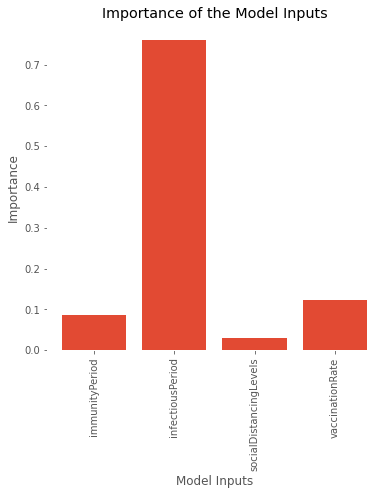

In [20]:
# Set the style
plt.figure(figsize=(6, 6))
importances = list(rf_final.feature_importances_)
x_values = list(range(len(importances)))
ax = plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, X_test.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Model Inputs')
plt.title('Importance of the Model Inputs')
plt.show()

In [21]:
rf_small = RandomForestRegressor(n_estimators=1000, max_depth = 4)
rf_small.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

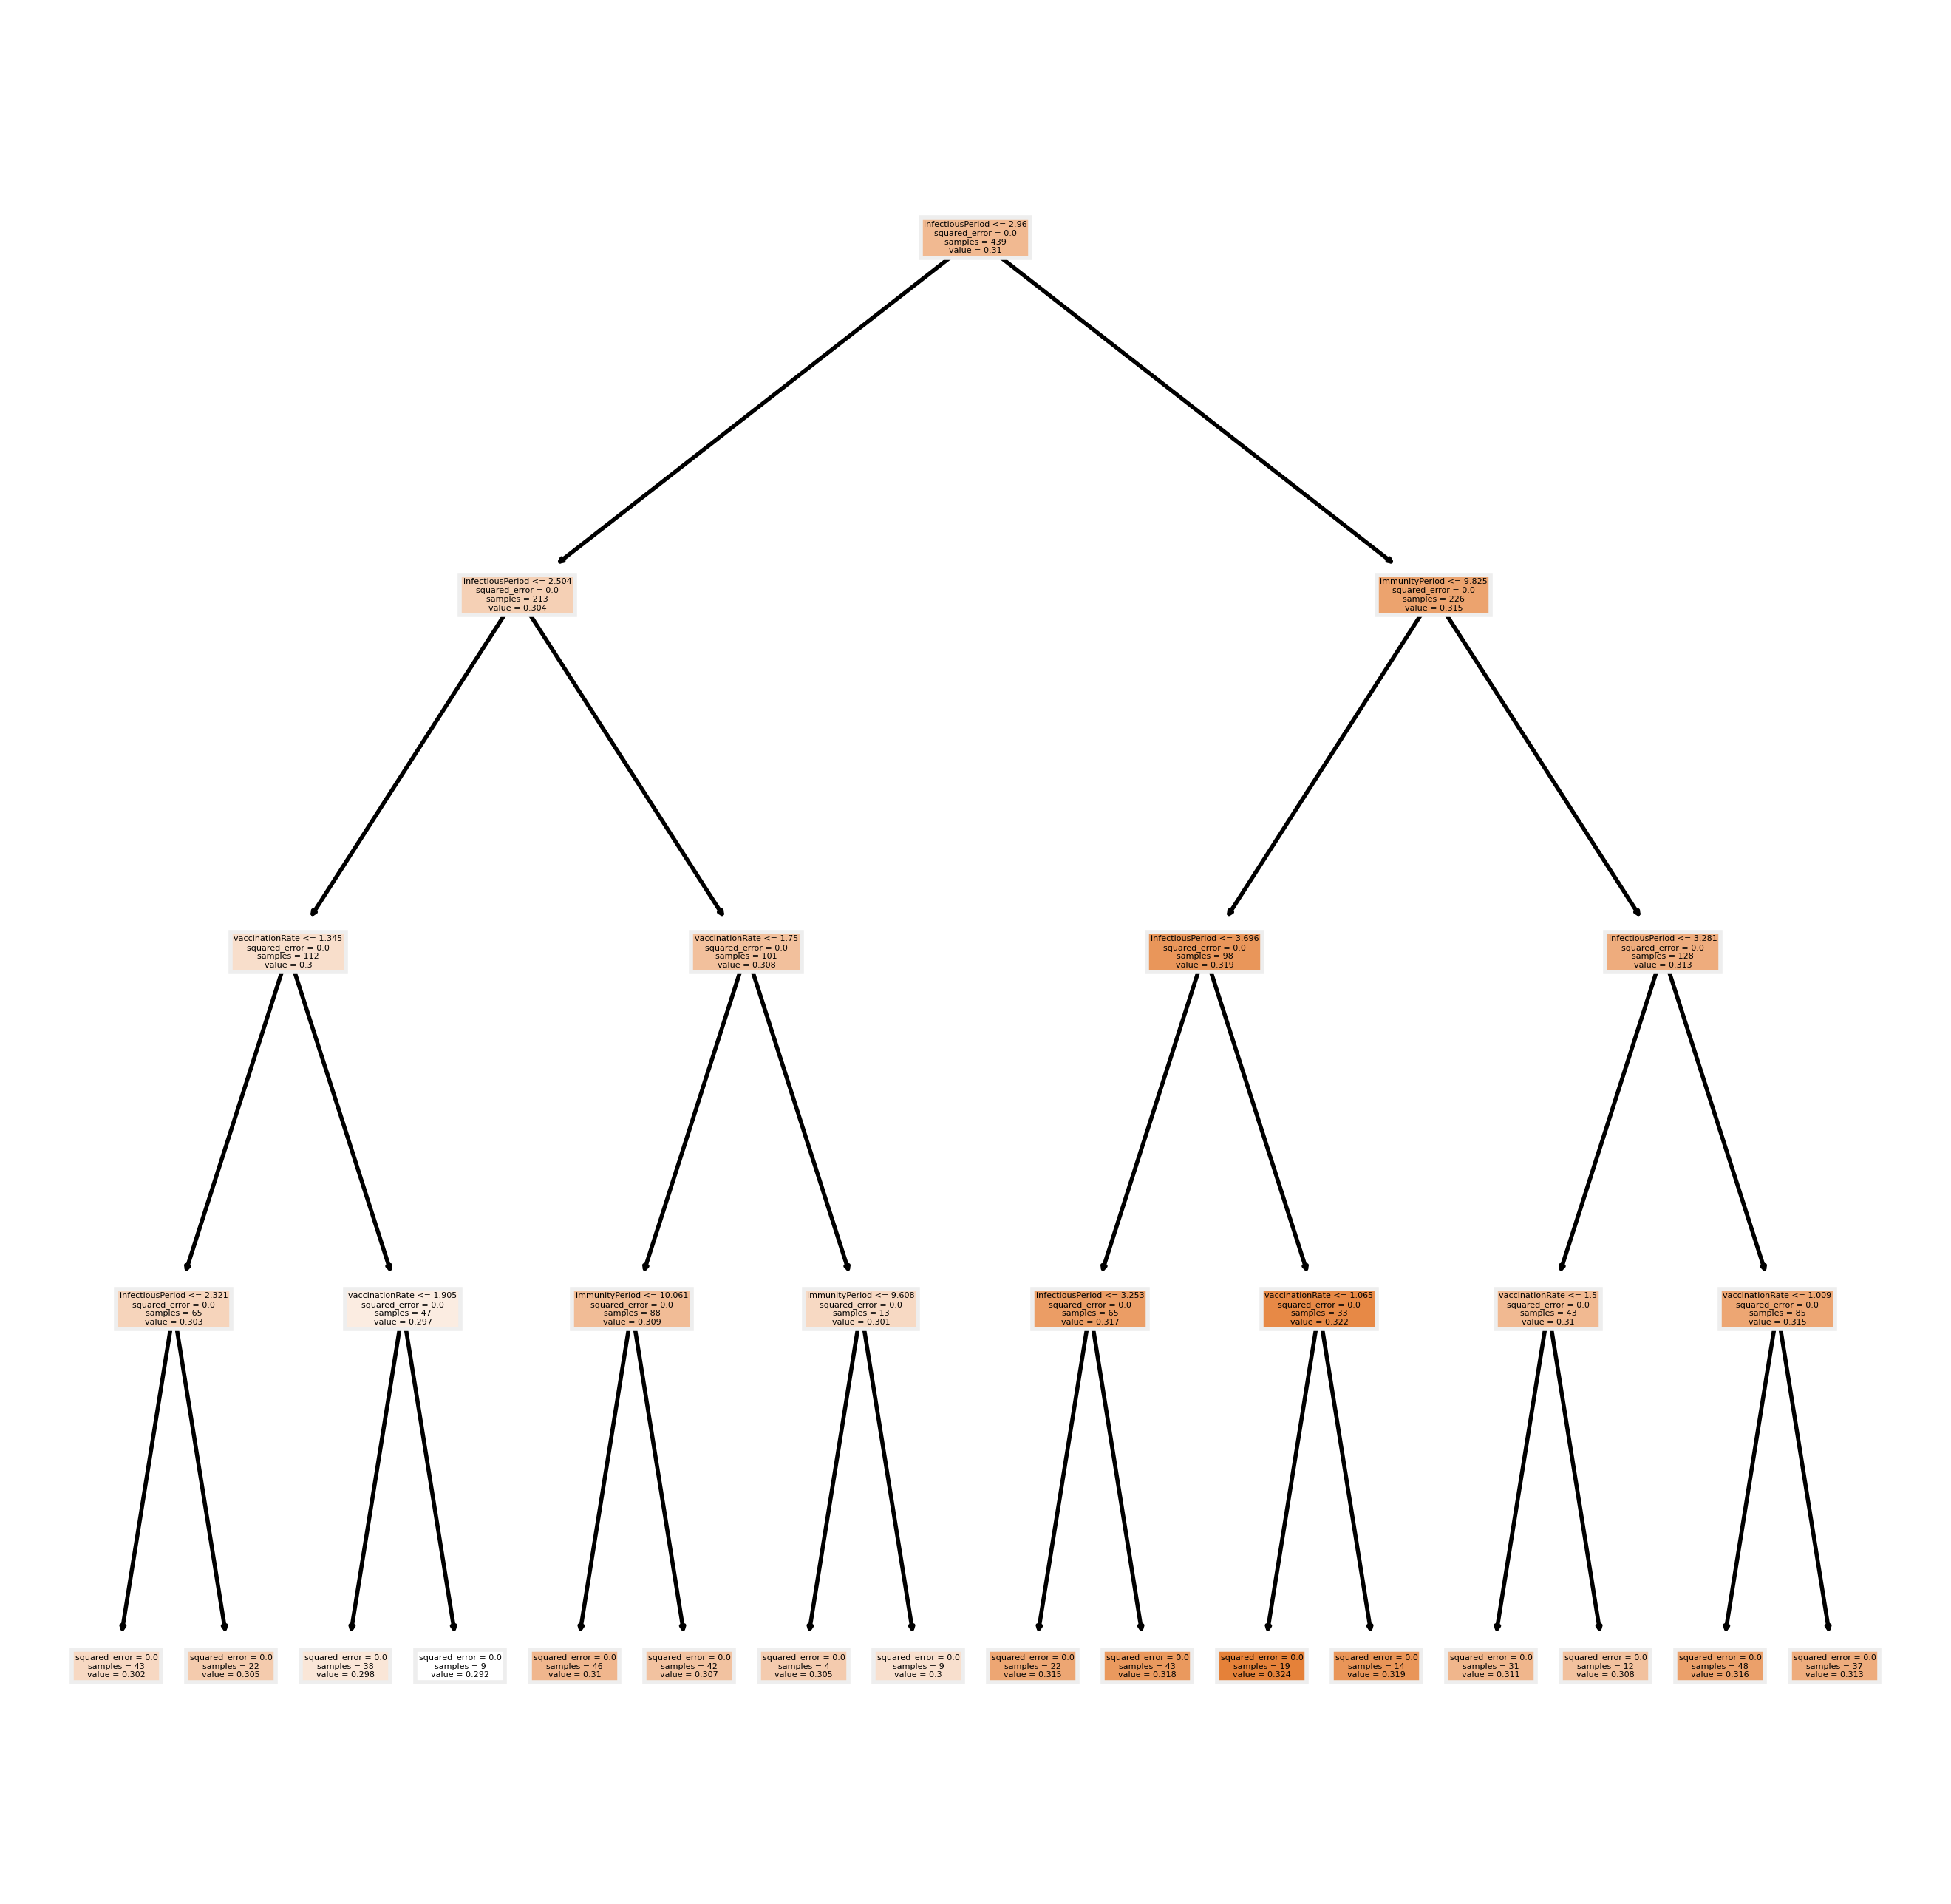

In [22]:
fn=X_test.columns
cn=y_test
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_small.estimators_[0], feature_names = fn, class_names=cn, filled = True)
fig.savefig('rf_final_individualtree.png')

C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\888071154.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\888071154.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\888071154.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\

Text(0.5, 1.0, 'ProportionVaccinated vs. Normal Distribution')

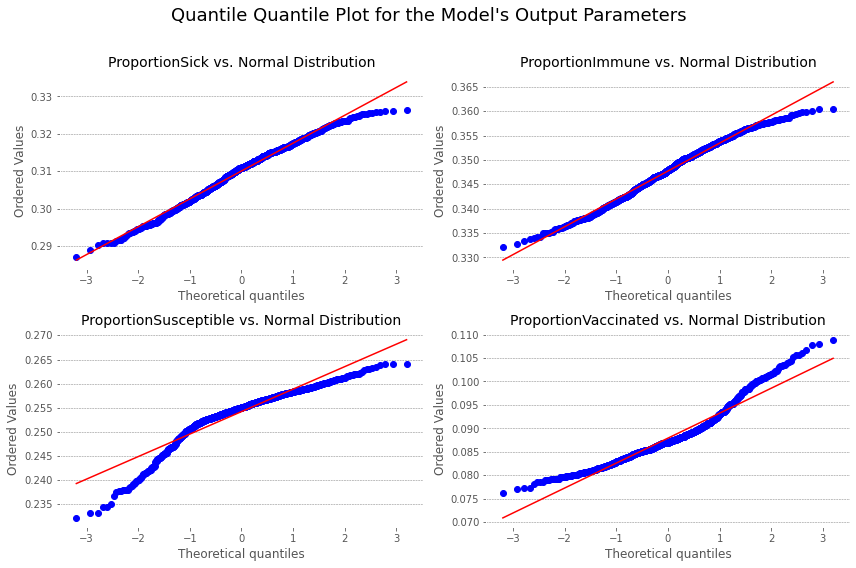

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), tight_layout=True)
fig.suptitle('Quantile Quantile Plot for the Model\'s Output Parameters\n', size=18)
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(221)
x = df['ProportionSick']
res = stats.probplot(x, plot=plt)
ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax1.set_title('ProportionSick vs. Normal Distribution', size=14)

ax2 = plt.subplot(222)
x = df['ProportionImmune']
res = stats.probplot(x, plot=plt)
ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax2.set_title('ProportionImmune vs. Normal Distribution', size=14)

ax3 = plt.subplot(223)
x = df['ProportionSusceptible']
res = stats.probplot(x, plot=plt)
ax3.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax3.set_title('ProportionSusceptible vs. Normal Distribution', size=14)

ax4 = plt.subplot(224)
x = df['ProportionVaccinated']
res = stats.probplot(x, plot=plt)
ax4.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax4.set_title('ProportionVaccinated vs. Normal Distribution', size=14)

C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\105268267.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\105268267.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\105268267.py:44: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData

Text(0.5, 1.0, "Histogram for the 'ProportionVaccinated'")

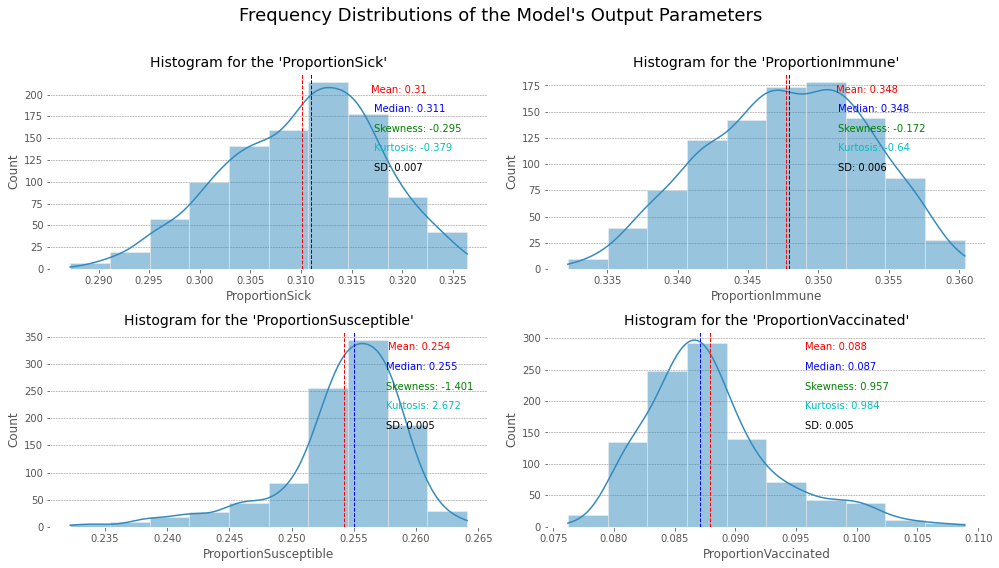

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8), tight_layout=True)
fig.suptitle('Frequency Distributions of the Model\'s Output Parameters\n', size=18)
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(221)
x = df['ProportionSick']
sns.histplot(x, bins=10, kde=True)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.022, max_ylim*0.9, f'Mean: {round(x.mean(),3)}', color='r', size=10)
plt.text(x.median()*1.02, max_ylim*0.8, f'Median: {round(x.median(),3)}', color='b', size=10)
plt.text(x.median()*1.02, max_ylim*0.5, f'SD: {round(x.std(),3)}', color='k', size=10)
plt.text(x.median()*1.02, max_ylim*0.7, f'Skewness: {round(skew(x),3)}', color='g', size=10)
plt.text(x.median()*1.02, max_ylim*0.6, f'Kurtosis: {round(kurtosis(x),3)}', color='c', size=10)
ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax1.set_title('Histogram for the \'ProportionSick\'', size=14)

ax2 = plt.subplot(222)
x = df['ProportionImmune']
sns.histplot(x, bins=10, kde=True)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.0102, max_ylim*0.9, f'Mean: {round(x.mean(),3)}', color='r', size=10)
plt.text(x.median()*1.01, max_ylim*0.8, f'Median: {round(x.median(),3)}', color='b', size=10)
plt.text(x.median()*1.01, max_ylim*0.5, f'SD: {round(x.std(),3)}', color='k', size=10)
plt.text(x.median()*1.01, max_ylim*0.7, f'Skewness: {round(skew(x),3)}', color='g', size=10)
plt.text(x.median()*1.01, max_ylim*0.6, f'Kurtosis: {round(kurtosis(x),3)}', color='c', size=10)
ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax2.set_title('Histogram for the \'ProportionImmune\'', size=14)

ax3 = plt.subplot(223)
x = df['ProportionSusceptible']
sns.histplot(x, bins=10, kde=True)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.014, max_ylim*0.9, f'Mean: {round(x.mean(),3)}'.format(x.mean()), color='r', size=10)
plt.text(x.median()*1.01, max_ylim*0.8, f'Median: {round(x.median(),3)}', color='b', size=10)
plt.text(x.median()*1.01, max_ylim*0.5, f'SD: {round(x.std(),3)}', color='k', size=10)
plt.text(x.median()*1.01, max_ylim*0.7, f'Skewness: {round(skew(x),3)}', color='g', size=10)
plt.text(x.median()*1.01, max_ylim*0.6, f'Kurtosis: {round(kurtosis(x),3)}', color='c', size=10)
ax3.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax3.set_title('Histogram for the \'ProportionSusceptible\'', size=14)

ax4 = plt.subplot(224)
x = df['ProportionVaccinated']
sns.histplot(x, bins=10, kde=True)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.089, max_ylim*0.9, f'Mean: {round(x.mean(),3)}'.format(x.mean()), color='r', size=10)
plt.text(x.median()*1.1, max_ylim*0.8, f'Median: {round(x.median(),3)}', color='b', size=10)
plt.text(x.median()*1.1, max_ylim*0.5, f'SD: {round(x.std(),3)}', color='k' ,size=10)
plt.text(x.median()*1.1, max_ylim*0.7, f'Skewness: {round(skew(x),3)}', color='g', size=10)
plt.text(x.median()*1.1, max_ylim*0.6, f'Kurtosis: {round(kurtosis(x),3)}', color='c', size=10)
ax4.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
ax4.set_title('Histogram for the \'ProportionVaccinated\'', size=14)

C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\2732921569.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ProportionSick', 'ProportionImmune', 'ProportionSusceptible', 'ProportionVaccinated'])
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\2732921569.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)


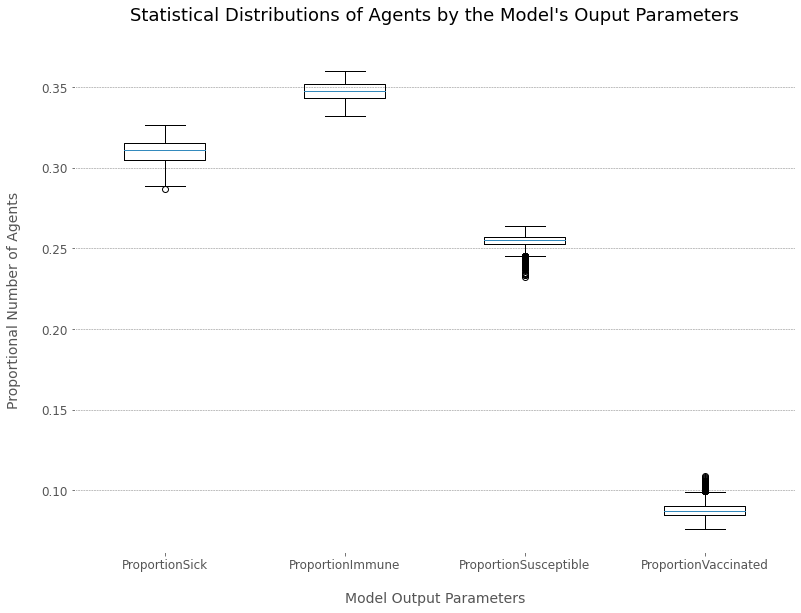

In [25]:
data_1 = df['ProportionSick']
data_2 = df['ProportionImmune']
data_3 = df['ProportionSusceptible']
data_4 = df['ProportionVaccinated']
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Statistical Distributions of Agents by the Model\'s Ouput Parameters\n', size=18)
ax.set_xlabel('\nModel Output Parameters', size=14)
ax.set_ylabel('Proportional Number of Agents\n', size=14)

# x-axis labels
ax.set_xticklabels(['ProportionSick', 'ProportionImmune', 'ProportionSusceptible', 'ProportionVaccinated'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Creating plot
bp = ax.boxplot(data)
ax.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
# show plot
plt.show()

In [26]:
df_DS = pd.read_csv('https://raw.githubusercontent.com/henry-kang-7/CASA0004/main/csv/DS.csv')

In [27]:
df_DS[['immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']].head(5)

,immunityPeriod,infectiousPeriod,socialDistancingLevels,vaccinationRate,ProportionImmune,ProportionSick,ProportionSusceptible,ProportionVaccinated
0,9,4,1,0.0000,0.3411,0.3280,0.2525,0.0785
1,9,4,2,0.0000,0.3401,0.3262,0.2545,0.0793
2,9,4,3,0.0000,0.3386,0.3244,0.2575,0.0795
3,10,4,1,0.0000,0.3386,0.3239,0.2530,0.0844
4,10,4,3,0.0000,0.3402,0.3235,0.2527,0.0837


In [28]:
# Sorting by column 'Country' 
top_5 = df_DS.sort_values(by=['ProportionSick'], ascending=True).head(5)
top_5 = top_5[['ProportionSick','immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate']]
top_5

,ProportionSick,immunityPeriod,infectiousPeriod,socialDistancingLevels,vaccinationRate
80,0.2779,11,2,3,0.0050
79,0.2781,10,2,3,0.0050
78,0.2784,9,2,3,0.0050
77,0.2810,9,2,2,0.0050
76,0.2811,11,2,2,0.0050


In [29]:
# Sorting by column 'Country' 
bottom_5 = df_DS.sort_values(by=['ProportionSick'], ascending=False).head(5)
bottom_5 = bottom_5[['ProportionSick','immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate']]
bottom_5

,ProportionSick,immunityPeriod,infectiousPeriod,socialDistancingLevels,vaccinationRate
0,0.3280,9,4,1,0.0000
1,0.3262,9,4,2,0.0000
2,0.3244,9,4,3,0.0000
3,0.3239,10,4,1,0.0000
4,0.3235,10,4,3,0.0000


In [30]:
df_temp = df_DS[['immunityPeriod','infectiousPeriod','socialDistancingLevels','vaccinationRate','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]
df_temp.head(10)

,immunityPeriod,infectiousPeriod,socialDistancingLevels,vaccinationRate,ProportionImmune,ProportionSick,ProportionSusceptible,ProportionVaccinated
0,9,4,1,0.0000,0.3411,0.3280,0.2525,0.0785
1,9,4,2,0.0000,0.3401,0.3262,0.2545,0.0793
2,9,4,3,0.0000,0.3386,0.3244,0.2575,0.0795
3,10,4,1,0.0000,0.3386,0.3239,0.2530,0.0844
4,10,4,3,0.0000,0.3402,0.3235,0.2527,0.0837
5,11,4,1,0.0000,0.3582,0.3225,0.2308,0.0885
6,9,4,2,0.0025,0.3375,0.3218,0.2554,0.0852
7,9,4,2,0.0025,0.3397,0.3215,0.2550,0.0837
8,11,4,2,0.0000,0.3577,0.3213,0.2326,0.0884
9,10,4,1,0.0025,0.3378,0.3206,0.2537,0.0879


In [31]:
df_infectious = df_temp[['infectiousPeriod','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]
df_immunity = df_temp[['immunityPeriod','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]
df_social = df_temp[['socialDistancingLevels','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]
df_vaccine = df_temp[['vaccinationRate','ProportionImmune','ProportionSick','ProportionSusceptible','ProportionVaccinated']]

df_infectious = df_infectious.groupby('infectiousPeriod')
df_immunity = df_immunity.groupby('immunityPeriod')
df_social = df_social.groupby('socialDistancingLevels')
df_vaccine = df_vaccine.groupby('vaccinationRate')

In [32]:
df_infectious_2 = df_infectious.get_group(2)
df_infectious_3 = df_infectious.get_group(3)
df_infectious_4 = df_infectious.get_group(4)

df_immunity_4 = df_immunity.get_group(9)
df_immunity_5 = df_immunity.get_group(10)
df_immunity_6 = df_immunity.get_group(11)

df_social_1 = df_social.get_group(1)
df_social_2 = df_social.get_group(2)
df_social_3 = df_social.get_group(3)

df_vaccine_0 = df_vaccine.get_group(0.0000)
df_vaccine_1 = df_vaccine.get_group(0.0025)
df_vaccine_2 = df_vaccine.get_group(0.005)

C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\262449702.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['2', '3', '4'])
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\262449702.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\262449702.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['7', '8', '9'])
C:\Users\gear7\AppData\Local\Temp\ipykernel_66200\262449702.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', l

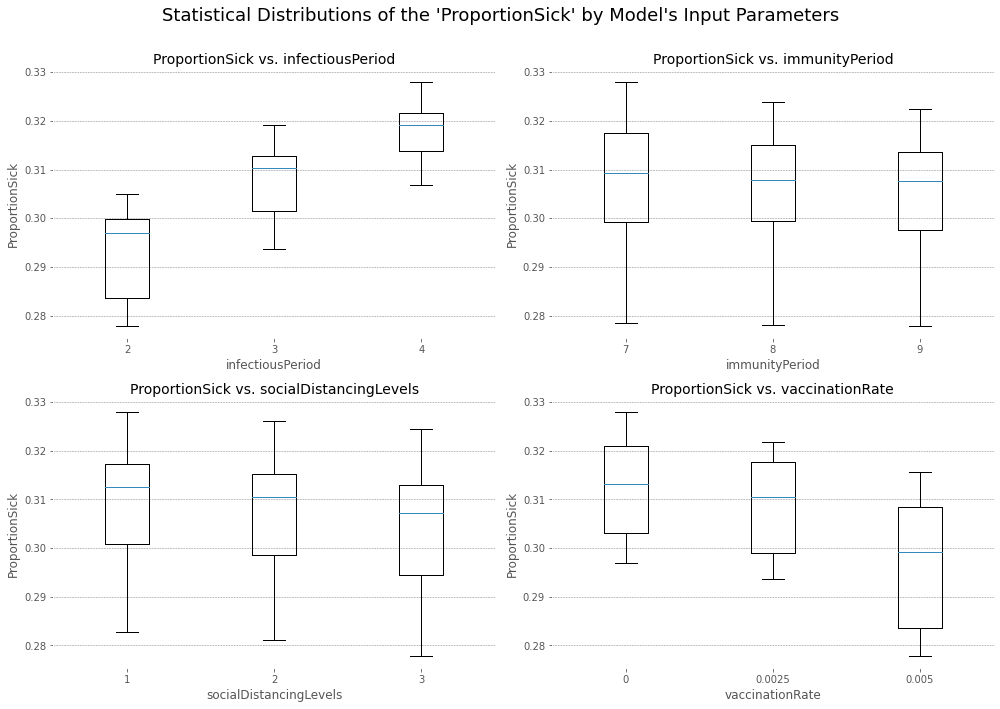

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10), tight_layout=True)
fig.suptitle('Statistical Distributions of the \'ProportionSick\' by Model\'s Input Parameters\n', size=18)
fig.subplots_adjust(top=0.88)
data_1 = df_infectious_2['ProportionSick']
data_2 = df_infectious_3['ProportionSick']
data_3 = df_infectious_4['ProportionSick']
data = [data_1, data_2, data_3]
ax1 = plt.subplot(221)
# Creating axes instance
ax1.set_xlabel('infectiousPeriod', size = 12)
ax1.set_ylabel('ProportionSick', size = 12)
# x-axis labels
ax1.set_xticklabels(['2', '3', '4'])
# Creating plot
plt.boxplot(data)
ax1.set_title('ProportionSick vs. infectiousPeriod', size=14)
ax1.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)



data_1 = df_immunity_4['ProportionSick']
data_2 = df_immunity_5['ProportionSick']
data_3 = df_immunity_6['ProportionSick']
data = [data_1, data_2, data_3]
ax2 = plt.subplot(222)
# Creating axes instance
ax2.set_xlabel('immunityPeriod', size = 12)
ax2.set_ylabel('ProportionSick', size = 12)
# x-axis labels
ax2.set_xticklabels(['7', '8', '9'])
# Creating plot
plt.boxplot(data)
ax2.set_title('ProportionSick vs. immunityPeriod', size=14)
ax2.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)


data_1 = df_social_1['ProportionSick']
data_2 = df_social_2['ProportionSick']
data_3 = df_social_3['ProportionSick']
data = [data_1, data_2, data_3]
ax3 = plt.subplot(223)
# Creating axes instance
ax3.set_xlabel('socialDistancingLevels', size = 12)
ax3.set_ylabel('ProportionSick', size = 12)
# x-axis labels
ax3.set_xticklabels(['1', '2', '3'])
# Creating plot
plt.boxplot(data)
ax3.set_title('ProportionSick vs. socialDistancingLevels', size=14)
ax3.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)


data_1 = df_vaccine_0['ProportionSick']
data_2 = df_vaccine_1['ProportionSick']
data_3 = df_vaccine_2['ProportionSick']
data = [data_1, data_2, data_3]
ax4 = plt.subplot(224)
# Creating axes instance
ax4.set_xlabel('vaccinationRate', size = 12)
ax4.set_ylabel('ProportionSick', size = 12)
# x-axis labels
ax4.set_xticklabels(['0', '0.0025', '0.005'])
# Creating plot
plt.boxplot(data)
ax4.set_title('ProportionSick vs. vaccinationRate', size=14)
ax4.yaxis.grid(b=True, which='major', color='grey', linestyle='--', linewidth=0.5)

In [44]:
n_estimators_range = [800,900,950,1000,1050]

train_scores, valid_scores = validation_curve(estimator=RandomForestRegressor(), 
                                              X=X_train, y=y_train, 
                                              param_name="n_estimators",
                                              param_range=n_estimators_range,
                                              cv=5)

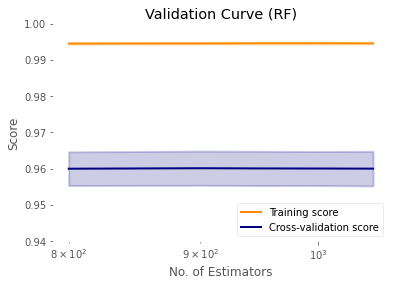

In [35]:
# plotting the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve (RF)")
plt.xlabel("No. of Estimators")
plt.ylabel("Score")
plt.ylim(0.94, 1.0)
lw = 2
plt.semilogx(n_estimators_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n_estimators_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="lower right")
plt.show()

In [36]:
temp = pd.read_csv('https://raw.githubusercontent.com/henry-kang-7/CASA0004/main/csv/GA.csv')

In [37]:
temp = temp[temp['evolution$samples'] > 10].reset_index()

In [38]:
temp = temp.drop(columns=['CumulativePopulation','CumulativeSick','CumulativeImmune','CumulativeSusceptible','CumulativeVaccinated'])

In [39]:
temp.head(10)

,index,evolution$generation,evolution$evaluated,infectiousPeriod,immunityPeriod,vaccinationRate,socialDistancingLevels,objective$ProportionSick,objective$ProportionVaccinated,evolution$samples,ProportionImmune,ProportionSusceptible,ProportionVaccinated,ProportionSick
0,0,10000,10000,2.0416,9.2521,0.0028,2.1111,0.2955,0.0940,28,"[0.357,0.354,0.348,0.354,0.352,0.353,0.347,0.3...","[0.244,0.253,0.266,0.258,0.263,0.261,0.264,0.2...","[0.104,0.098,0.094,0.087,0.087,0.088,0.09,0.08...","[0.295,0.295,0.292,0.301,0.298,0.298,0.299,0.2..."
1,1,10000,10000,3.6433,9.0508,0.0000,1.0000,0.3260,0.0765,22,"[0.338,0.349,0.34,0.343,0.338,0.342,0.337,0.35...","[0.259,0.251,0.254,0.257,0.258,0.257,0.262,0.2...","[0.074,0.073,0.077,0.07,0.076,0.075,0.075,0.08...","[0.329,0.327,0.329,0.33,0.328,0.326,0.325,0.32..."
2,12,10000,10000,2.0000,9.4315,0.0012,2.5487,0.3000,0.0820,11,"[0.346,0.355,0.351,0.355,0.355,0.36,0.349,0.35...","[0.275,0.252,0.267,0.261,0.262,0.251,0.272,0.2...","[0.079,0.089,0.082,0.082,0.084,0.091,0.08,0.07...","[0.299,0.304,0.301,0.302,0.299,0.299,0.3,0.303..."
3,13,10000,10000,2.0000,10.4712,0.0028,2.9112,0.2915,0.0925,12,"[0.35,0.355,0.351,0.353,0.348,0.346,0.351,0.35...","[0.267,0.254,0.258,0.259,0.27,0.274,0.264,0.25...","[0.091,0.101,0.095,0.096,0.091,0.092,0.091,0.1...","[0.291,0.289,0.296,0.292,0.291,0.288,0.294,0.2..."
4,14,10000,10000,2.0000,9.0000,0.0050,2.9738,0.2770,0.1220,13,"[0.331,0.34,0.328,0.338,0.332,0.332,0.339,0.33...","[0.27,0.259,0.278,0.259,0.267,0.274,0.268,0.26...","[0.129,0.122,0.116,0.127,0.121,0.12,0.118,0.11...","[0.27,0.279,0.278,0.275,0.279,0.274,0.275,0.28..."
5,15,10000,10000,2.1656,9.5613,0.0011,1.0804,0.3045,0.0810,14,"[0.35,0.36,0.355,0.356,0.361,0.35,0.355,0.346,...","[0.28,0.254,0.261,0.253,0.249,0.266,0.26,0.275...","[0.067,0.081,0.079,0.088,0.085,0.081,0.079,0.0...","[0.303,0.305,0.306,0.303,0.304,0.303,0.306,0.3..."
6,16,10000,10000,2.0008,10.2995,0.0033,2.5298,0.2900,0.1020,15,"[0.352,0.353,0.343,0.343,0.347,0.347,0.341,0.3...","[0.252,0.257,0.267,0.261,0.259,0.254,0.266,0.2...","[0.111,0.097,0.1,0.098,0.104,0.116,0.104,0.095...","[0.285,0.292,0.289,0.299,0.29,0.283,0.29,0.294..."
7,17,10000,10000,2.0000,9.4402,0.0011,2.7153,0.3000,0.0830,17,"[0.355,0.354,0.36,0.36,0.357,0.353,0.352,0.348...","[0.266,0.259,0.258,0.252,0.26,0.271,0.269,0.27...","[0.08,0.092,0.083,0.088,0.083,0.084,0.076,0.08...","[0.299,0.296,0.298,0.3,0.3,0.292,0.303,0.298,0..."
8,18,10000,10000,2.4564,9.2785,0.0007,1.8760,0.3100,0.0800,23,"[0.355,0.352,0.348,0.358,0.36,0.354,0.36,0.354...","[0.264,0.259,0.266,0.257,0.246,0.258,0.252,0.2...","[0.069,0.078,0.081,0.079,0.086,0.075,0.08,0.08...","[0.312,0.312,0.305,0.307,0.308,0.313,0.308,0.3..."
9,19,10000,10000,2.0074,9.0000,0.0048,2.8882,0.2780,0.1220,16,"[0.329,0.339,0.339,0.34,0.343,0.336,0.345,0.33...","[0.274,0.265,0.262,0.255,0.263,0.269,0.25,0.26...","[0.119,0.118,0.122,0.124,0.113,0.116,0.127,0.1...","[0.277,0.278,0.277,0.281,0.282,0.279,0.278,0.2..."


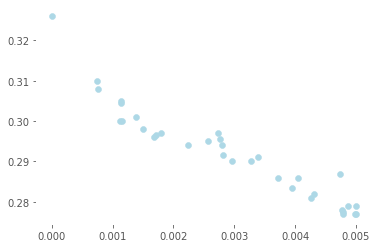

In [40]:
plt.scatter(temp['vaccinationRate'],temp['objective$ProportionSick'], color='lightblue')
plt.show()

In [41]:
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):

    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    p_front = [myList[0]]    

    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]:
                p_front.append(pair)
        else:
            if pair[1] <= p_front[-1][1]:
                p_front.append(pair)
                
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

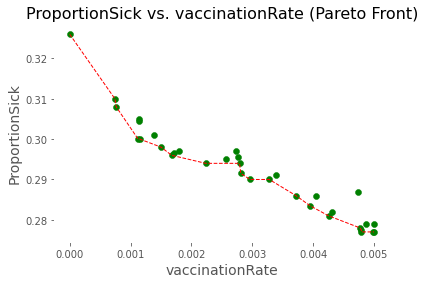

In [42]:
Xs = temp['vaccinationRate'] 
Ys = temp['objective$ProportionSick']

p_front = pareto_frontier(Xs, Ys, maxX = False, maxY = False) 

plt.scatter(Xs, Ys, color='green')
plt.plot(p_front[0], p_front[1], color='red', linestyle='dashed',linewidth=1, markersize=1)
plt.xlabel('vaccinationRate', fontsize=14)
plt.ylabel('ProportionSick', fontsize=14)
plt.title('ProportionSick vs. vaccinationRate (Pareto Front)', fontsize=16)
plt.show()

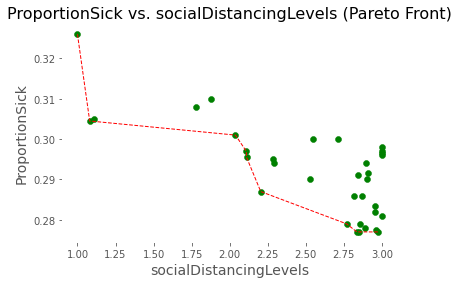

In [43]:
Xs = temp['socialDistancingLevels'] 
Ys = temp['objective$ProportionSick']

p_front = pareto_frontier(Xs, Ys, maxX = False, maxY = False) 

plt.scatter(Xs, Ys, color='green')
plt.plot(p_front[0], p_front[1], color='red', linestyle='dashed',linewidth=1, markersize=1)
plt.xlabel('socialDistancingLevels', fontsize=14)
plt.ylabel('ProportionSick', fontsize=14)

plt.title('ProportionSick vs. socialDistancingLevels (Pareto Front)', fontsize=16)
plt.show()